<a href="https://colab.research.google.com/github/chinmay002/Tensorflow_cert_progress/blob/main/TF_NLP_SKIMLIT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow.keras import layers,models
from tensorflow.keras.layers import Dense,Conv1D,Input
from tensorflow.keras.models import Model,Sequential

from sklearn.metrics import classification_report,confusion_matrix,f1_score,accuracy_score,precision_score,recall_score
import random,os,glob
import zipfile
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline


In [3]:

!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), 177.08 MiB | 9.89 MiB/s, done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [4]:
data_dir  ='/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign'

In [5]:
def get_lines(filename):
  with open(filename,'r') as f:
    '''
    Returns:
    A list of strings with one string per line from the target filename
    '''
    return f.readlines()


In [6]:
train_lines = get_lines(data_dir+'/train.txt')
train_lines[:15]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 



```

 [{line_numer:0,
 'target':'OBJECTIVE',
 'A total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'total_lines :11'}]
```




In [7]:
def preprocess_text_with_line_numbers(filename):
  """Returns a list of dictionaries of abstract line data.

  Takes in filename, reads its contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence number
  the target line is.

  Args:
      filename: a string of the target text file to read and extract line data
      from.

  Returns:
      A list of dictionaries each containing a line from an abstract,
      the lines label, the lines position in the abstract and the total number
      of lines in the abstract where the line is from. For example:

      [{"target": 'CONCLUSION',
        "text": The study couldn't have gone better, turns out people are kinder than you think",
        "line_number": 8,
        "total_lines": 8}]
  """
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts
  
  # Loop through each line in target file
  for line in input_lines:
    if line.startswith("###"): # check to see if line is an ID line
      abstract_id = line
      abstract_lines = "" # reset abstract string
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create empty dict to store data from line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are in the abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list
    
    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line
  
  return abstract_samples

In [9]:
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "/train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "/dev.txt") # dev is another name for validation set
test_samples = preprocess_text_with_line_numbers(data_dir + "/test.txt")
len(train_samples), len(val_samples), len(test_samples)

CPU times: user 402 ms, sys: 115 ms, total: 517 ms
Wall time: 520 ms


(180040, 30212, 30135)

In [8]:
train_samples[:10]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [10]:
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)
     

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


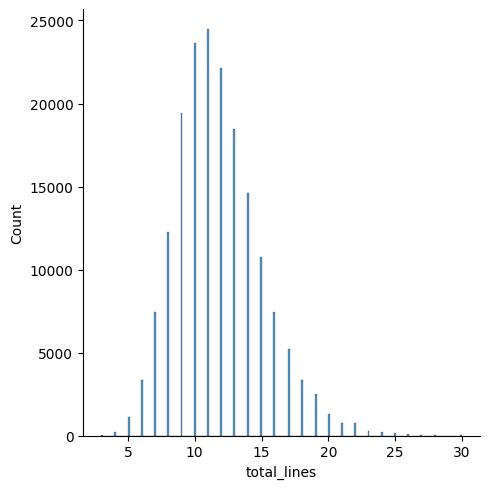

In [10]:
sns.displot(train_df['total_lines'])

In [11]:
train_sent = train_df['text'].tolist()
val_sent = val_df['text'].tolist()
test_sent = test_df['text'].tolist()

In [12]:
train_sent[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

In [12]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse=False)
train_labels_ohe = ohe.fit_transform(train_df['target'].values.reshape(-1, 1))
val_labels_ohe = ohe.fit_transform(val_df['target'].values.reshape(-1, 1))
test_labels_ohe = ohe.fit_transform(test_df['target'].values.reshape(-1, 1))

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [14]:
train_labels_ohe

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

# Label Encoder

In [13]:
from sklearn.preprocessing import LabelEncoder

lb = LabelEncoder()
train_labels_encoded = lb.fit_transform(train_df['target'].to_numpy())
test_labels_encoded = lb.fit_transform(test_df['target'].to_numpy())
val_labels_encoded = lb.fit_transform(val_df['target'].to_numpy())

In [16]:
n_classes,class_names = len(lb.classes_),lb.classes_

#Model 0: Baseline

In [17]:
model_0 = Pipeline([
  ("tf-idf", TfidfVectorizer()),
  ("clf", MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(X=train_sent, 
            y=train_labels_encoded);
     

In [18]:
print(model_0.score(X=val_sent,y=val_labels_encoded))

# Make predictions
baseline_preds = model_0.predict(val_sent)
baseline_preds


0.7218323844829869


array([4, 1, 3, ..., 4, 4, 1])

In [14]:
def plot_loss_curve(history):
  
  acc = history.history['accuracy']
  loss = history.history['loss']

  val_acc = history.history['val_accuracy']
  val_loss = history.history['val_loss']

  fig = plt.figure(figsize=(10,5))

  plt.subplot(221)
  plt.plot(acc,'bo--', label = "acc")
  plt.plot(val_acc,'ro--',label = 'val_acc')
  plt.ylabel('accuracy')
  plt.xlabel('epochs')
  plt.title('acc vs val_acc')
  plt.legend()

  plt.subplot(222)
  plt.plot(loss,'bo--', label = "loss")
  plt.plot(val_loss,'ro--',label = 'val_acc')
  plt.ylabel('Loss')
  plt.xlabel('epochs')
  plt.title('loss vs val_loss')
  plt.legend()
  plt.show()

def unzip_data(file):
  zip_file = zipfile.ZipFile(file)
  zip_file.extractall()
  zip_file.close()


import datetime

def create_tensorboard_callback(dir_name,experiment_name):
  
  log_dir = dir_name + '/' + experiment_name + '/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir)
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback


def calculate(y_true_,y_pred):
  acc = accuracy_score(y_true_,y_pred)
  f1 = f1_score(y_true_,y_pred,average = 'weighted')
  recall = recall_score(y_true_,y_pred,average = 'weighted')
  precision = precision_score(y_true_,y_pred,average = 'weighted')

  print('Recall: ', recall)
  print('precision: ', precision)
  print('f1: ', f1)
  print('accuracy: ', acc)
  return {'accuracy': acc,
          'f1': f1,
          'precision': precision,
          'Recall': recall,}


In [20]:
baseline_results = calculate(val_labels_encoded,baseline_preds)

Recall:  0.7218323844829869
precision:  0.7186466952323352
f1:  0.6989250353450294
accuracy:  0.7218323844829869


In [21]:
#max_length avg_sentnece lentgth
sum(train_df['text'].str.split(' ').str.len())/len(train_df)



26.338269273494777

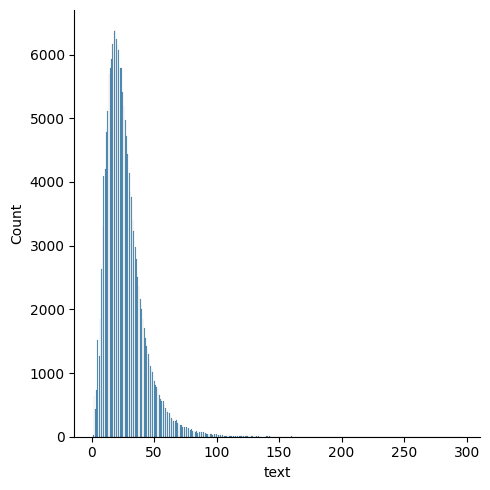

In [22]:
sns.displot(train_df['text'].str.split(' ').str.len())

In [18]:
#skwed token_length 
output_seq_len = np.percentile(train_df['text'].str.split(' ').str.len(),95)
output_seq_len

#looks loke 95% of the token_lentgh have 55 tokens in sentence

55.0

In [24]:
import nltk
tr = ' '.join(train_df['text'].str.lower())


In [25]:
import nltk
nltk.download('punkt')
nltk.FreqDist(nltk.word_tokenize(tr))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


FreqDist({'@': 337420, ',': 196305, '.': 180578, 'the': 171178, 'and': 137947, 'of': 130660, ')': 129028, '(': 128312, 'in': 106651, 'to': 76228, ...})

In [26]:
len(nltk.word_tokenize(tr))

4846116

In [16]:
max_tokens = 68000
max_tokens

68000

# TextVectorization

In [19]:
from tensorflow.keras.layers import TextVectorization

tv = TextVectorization(max_tokens=max_tokens,
                       standardize = 'lower_and_strip_punctuation',
                       split = 'whitespace',
                       ngrams = None,
                       pad_to_max_tokens=True,
                       output_mode = 'int',
                       output_sequence_length = int(output_seq_len))

In [20]:
tv.adapt(train_sent)

In [30]:
sample_sent = random.choice(train_sent)
print(f"Original Train {sample_sent}")
print(f"tv train {tv(sample_sent)}")

Original Train the patients in the first group received txa irrigation with normal saline ( @ mg/ml ) , and the patients in the second group had normal saline for irrigation during orthognathic surgery .
tv train [    2    12     5     2   152    13    80  4614  2631     7   417   622
  3976     3     2    12     5     2   480    13    55   417   622    11
  2631    52 11478   115     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0]


In [31]:
rct_20k_vocab = (tv.get_vocabulary())
print(f"Number of words in vocabulary: {len(rct_20k_vocab)}"), 
print(f"Most common words in the vocabulary: {rct_20k_vocab[:5]}")
print(f"Least common words in the vocabulary: {rct_20k_vocab[-5:]}")

Number of words in vocabulary: 64841
Most common words in the vocabulary: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocabulary: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [21]:
token_emb = layers.Embedding(input_dim =len(rct_20k_vocab) ,output_dim = 128 ,
                             mask_zero=True,
                             name="token_embedding")

import random
random_text = random.choice(train_sent)
print(f"Original text {random_text}\n \
        \n\nEmbedded Version: ")
sample_embed = token_emb(tv([random_text]))
print(sample_embed)

NameError: ignored

In [33]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_sent,train_labels_ohe))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sent,test_labels_ohe))
val_dataset = tf.data.Dataset.from_tensor_slices((val_sent,val_labels_ohe))

In [34]:

# Take the TensorSliceDataset's and turn them into prefetched batches
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [35]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

# Model 1

In [36]:
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = tv(inputs) # vectorize text inputs
token_embeddings = token_emb(text_vectors) # create embedding
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x) # condense the output of our feature vector
outputs = layers.Dense(n_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

# Compile
model_1.compile(loss="categorical_crossentropy", # if your labels are integer form (not one hot) use sparse_categorical_crossentropy
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [37]:
model_1.history = model_1.fit(train_dataset,epochs=3,
                              validation_data = val_dataset,
                              validation_steps = int(0.1*len(val_dataset)))

Epoch 1/3
5627/5627 [==============================] - 90s 14ms/step - loss: 0.6169 - accuracy: 0.7753 - val_loss: 0.5463 - val_accuracy: 0.8009
Epoch 2/3
5627/5627 [==============================] - 35s 6ms/step - loss: 0.4532 - accuracy: 0.8413 - val_loss: 0.5388 - val_accuracy: 0.7982
Epoch 3/3
5627/5627 [==============================] - 35s 6ms/step - loss: 0.3718 - accuracy: 0.8730 - val_loss: 0.5688 - val_accuracy: 0.7972


In [39]:
model_1.evaluate(val_dataset)

945/945 [==============================] - 7s 8ms/step - loss: 0.5681 - accuracy: 0.8060


[0.5680784583091736, 0.8060042262077332]

In [40]:
model_1_pred_probs = model_1.predict(val_dataset)
model_1_pred_probs = tf.argmax(model_1_pred_probs,axis=1)

945/945 [==============================] - 5s 5ms/step


In [41]:
baseline_1_res = calculate(val_labels_encoded,model_1_pred_probs)

Recall:  0.8060042367271283
precision:  0.8029659911007224
f1:  0.8035693570243317
accuracy:  0.8060042367271283


#Model 2: Feature Exctraction with pretrained token embeddings

In [30]:
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [43]:
sample_sent = random.choice(train_sent)
print(sample_sent)
print()
print(token_emb(tv(sample_sent)).shape)
print()
print(tf_hub_embedding_layer([sample_sent]).shape)

ct and cvp showed a complete caloric compensation ( scores > @ ) .

(55, 128)

(1, 512)


In [44]:
inputs = Input(shape=[],dtype = tf.string) #pretrained asks for size(batch,) hence shape= []
pretrained_emb = tf_hub_embedding_layer(inputs)
x = Dense(64,activation = 'relu')(pretrained_emb)
outputs = Dense(5,activation = 'softmax')(x)
model_2 = Model(inputs,outputs)
model_2.compile(loss="categorical_crossentropy", # if your labels are integer form (not one hot) use sparse_categorical_crossentropy
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_1 (Dense)             (None, 64)                32832     
                                                                 
 dense_2 (Dense)             (None, 5)                 325       
                                                                 
Total params: 256,830,981
Trainable params: 33,157
Non-trainable params: 256,797,824
_________________________________________________________________


In [45]:
model_2.fit(train_dataset,
            steps_per_epoch=int(0.1 * len(train_dataset)),
            epochs=3,
            validation_data=val_dataset,
            validation_steps=int(0.1 * len(val_dataset)))

Epoch 1/3
562/562 [==============================] - 11s 15ms/step - loss: 0.9556 - accuracy: 0.6409 - val_loss: 0.8048 - val_accuracy: 0.6875
Epoch 2/3
562/562 [==============================] - 8s 14ms/step - loss: 0.7800 - accuracy: 0.6957 - val_loss: 0.7653 - val_accuracy: 0.7021
Epoch 3/3
562/562 [==============================] - 7s 13ms/step - loss: 0.7672 - accuracy: 0.7052 - val_loss: 0.7549 - val_accuracy: 0.7074


In [46]:
print(model_2.evaluate(val_dataset))
model_2_pred_probs = model_2.predict(val_dataset)
model_2_pred_probs = tf.argmax(model_2_pred_probs,axis=1)
baseline_2_res = calculate(val_labels_encoded,model_2_pred_probs)

945/945 [==============================] - 11s 12ms/step - loss: 0.7554 - accuracy: 0.7082
[0.7553541660308838, 0.7082285284996033]
945/945 [==============================] - 11s 11ms/step
Recall:  0.7082285184694823
precision:  0.7079712422923568
f1:  0.7048251857533032
accuracy:  0.7082285184694823


#Model 3 : Conv1d with character Embeding

In [22]:
def char_split(sent):
  return ' '.join(list(sent))

char_split(sample_sent)

NameError: ignored

In [23]:
train_chars = [char_split(sent) for sent in train_sent]
val_chars = [char_split(sent) for sent in val_sent]
test_chars = [char_split(sent) for sent in test_sent]

In [49]:
train_chars[0]

't o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .'

In [24]:
# What's the average character length?
char_lens = [len(sentence) for sentence in train_sent]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

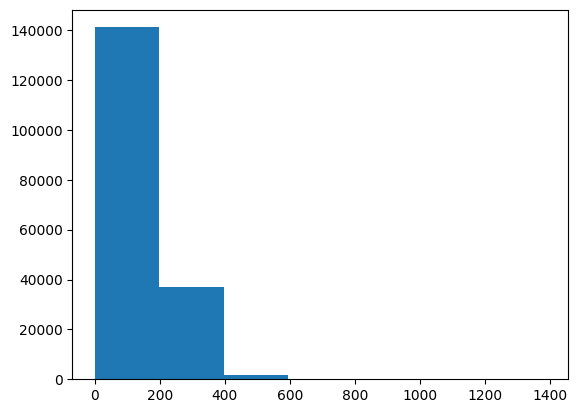

In [51]:
# Check the distribution of our sequences at character-level
import matplotlib.pyplot as plt
plt.hist(char_lens, bins=7);

In [25]:
output_seq_char_len = int(np.percentile(char_lens,95))
output_seq_char_len

290

In [26]:
# Get all keyboard characters for char-level embedding
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet


'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [54]:
train_chars[0]

't o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .'

In [27]:
max_tokens = len(alphabet) + 2 #num_of_alphbets + space + oov
tv_char = TextVectorization(max_tokens=max_tokens,  
                                    output_sequence_length=output_seq_char_len,
                                    standardize="lower_and_strip_punctuation",
                                    name="char_vectorizer")
tv_char.adapt(train_chars)


In [56]:
print(train_chars[0])
print(tv_char(train_chars[0]))

t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .
tf.Tensor(
[ 3  7  4  6 21  2  9  3  4 18  5  3  2  3 13  2  2 17 17  4 11  5 11 19
  7 17 20  2  2 23  9  7 17 10  5  4 12 19 12  7 20 10  7  9  2  7  8  5
 12 14  8  2 10  6  4  9  7 12  7  6  2  4  6  4 15 14  8  7 21  4  6 18
 14  5  4  6 15  7 22  4 12  4  3 19  5  6 10  9 19  9  3  2 15  4 11 12
  7 20 18  8  5 10  2  4  6 17 12  5 15 15  5  3  4  7  6  4  6  3 13  2
  9 13  7  8  3  3  2  8 15  5  6 10 20 13  2  3 13  2  8  3 1

In [28]:

# Create char embedding layer
char_embed = layers.Embedding(input_dim=max_tokens, # number of different characters
                              output_dim=25, # embedding dimension of each character (same as Figure 1 in https://arxiv.org/pdf/1612.05251.pdf)
                              mask_zero=False, # don't use masks (this messes up model_5 if set to True)
                              name="char_embed")
a =train_chars[0]

# Test out character embedding layer
print(f"Charified text (before vectorization and embedding):\n{a}\n")
char_embed_example = char_embed(tv_char([a]))
print(f"Embedded chars (after vectorization and embedding):\n{char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text (before vectorization and embedding):
t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .

Embedded chars (after vectorization and embedding):
[[[-0.04548379 -0.00843043  0.04414207 ...  0.00768463  0.02887024
    0.00188534]
  [ 0.01924815  0.02369085  0.03036925 ... -0.01496975 -0.0161059
   -0.03431183]
  [ 0.04015765 -0.04591969  0.01523964 ...  0.03524585  0.02112779
    0.02209523]
  ...
  [-0.04692407  0.02676097 -0.01958879 ... -0.00660144 -0.02806296
    0.02691

In [58]:

# Make Conv1D on chars only
inputs = layers.Input(shape=(1,), dtype="string")
char_vectors = tv_char(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(n_classes, activation="softmax")(x)
model_3 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name="model_3_conv1D_char_embedding")

# Compile model
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [59]:
model_3.summary()

Model: "model_3_conv1D_char_embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 290, 25)           1750      
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_3 (Dense)             (None, 5

In [60]:
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars,train_labels_ohe)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars,test_labels_ohe)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars,val_labels_ohe)).batch(32).prefetch(tf.data.AUTOTUNE)

In [61]:
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_dataset)),
                              epochs=3,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1 * len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 5s 6ms/step - loss: 1.2575 - accuracy: 0.4907 - val_loss: 1.0280 - val_accuracy: 0.5851
Epoch 2/3
562/562 [==============================] - 4s 7ms/step - loss: 0.9960 - accuracy: 0.6009 - val_loss: 0.9272 - val_accuracy: 0.6290
Epoch 3/3
562/562 [==============================] - 3s 5ms/step - loss: 0.9212 - accuracy: 0.6382 - val_loss: 0.8656 - val_accuracy: 0.6629


In [62]:
print(model_3.evaluate(val_dataset))
model_3_pred_probs = model_3.predict(val_dataset)
model_3_pred_pred = tf.argmax(model_3_pred_probs,axis=1)
baseline_3_res = calculate(val_labels_encoded,model_3_pred_pred)

945/945 [==============================] - 3s 3ms/step - loss: 1.5637 - accuracy: 0.4197
[1.5637239217758179, 0.41966769099235535]
945/945 [==============================] - 2s 2ms/step
Recall:  0.4196676817158745
precision:  0.3871363060225326
f1:  0.3332423683465643
accuracy:  0.4196676817158745


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#Model 4 : Combinig pretrained token and char embeddings

In [64]:
tok_inputs = Input(shape=[],dtype = tf.string) #pretrained asks for size(batch,) hence shape= []
tok_emb = tf_hub_embedding_layer(tok_inputs)
x = Dense(64,activation = 'relu')(tok_emb)
tok_outputs = Dense(5,activation = 'softmax')(x)
tok_model = Model(tok_inputs,tok_outputs)


char_inputs = layers.Input(shape=(1,), dtype="string")
char_vectors = tv_char(char_inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
char_outputs = Dense(n_classes, activation="softmax")(x)
char_model = Model(char_inputs,char_outputs)

comb_out = layers.Concatenate()([tok_model.output,char_model.output])
comb_drop = layers.Dropout(0.5)(comb_out)
comb_dense = Dense(200,activation = 'relu')(comb_drop)
final_drop = layers.Dropout(0.5)(comb_dense)
out_layer = Dense(n_classes,activation='softmax')(final_drop)

model_4 = Model([tok_model.input,char_model.input],outputs = out_layer)

In [65]:
model_4.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['input_5[0][0]']                
 tion)                                                                                            
                                                                                                  
 input_4 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 char_embed (Embedding)         (None, 290, 25)      1750        ['char_vectorizer[1][0]']  

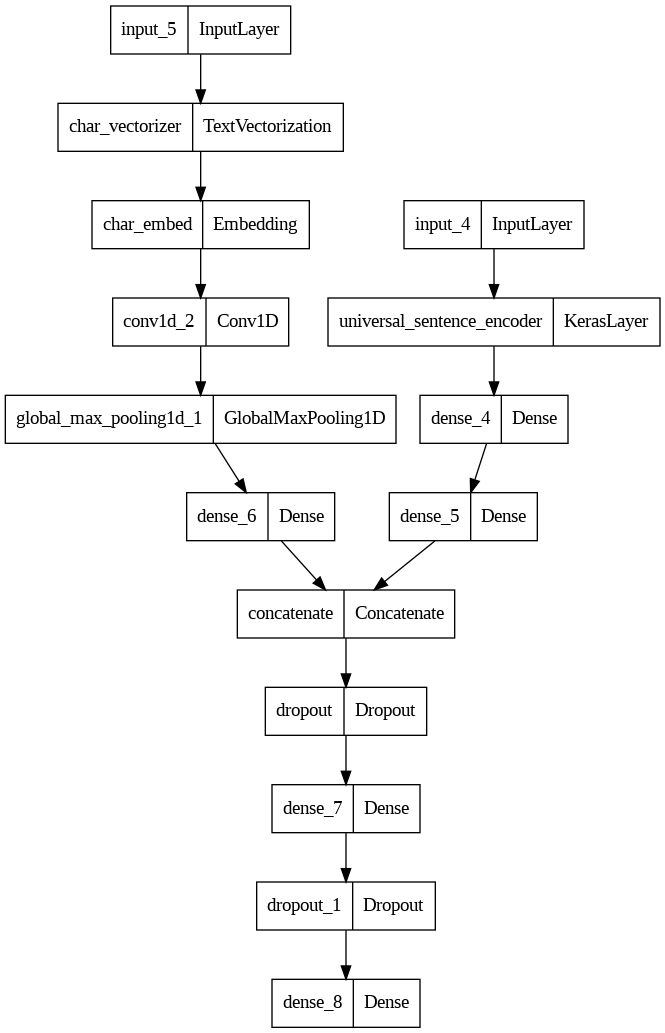

In [66]:
from tensorflow.keras.utils import plot_model
plot_model(model_4)

In [67]:
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(), # section 4.2 of https://arxiv.org/pdf/1612.05251.pdf mentions using SGD but we'll stick with Adam
                metrics=["accuracy"])

In [68]:
#combining token and char data 

train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sent,train_chars))
train_char_token_labels = tf.data.Dataset.from_tensor_slices((train_labels_ohe))
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data,train_char_token_labels))
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sent,val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices((val_labels_ohe))
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data,val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [69]:
# Fit the model on tokens and chars
model_4_history = model_4.fit(train_char_token_dataset, # train on dataset of token and characters
                              steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                              epochs=3,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1 * len(val_char_token_dataset)))
     

Epoch 1/3
562/562 [==============================] - 13s 18ms/step - loss: 1.2829 - accuracy: 0.4406 - val_loss: 0.9540 - val_accuracy: 0.6290
Epoch 2/3
562/562 [==============================] - 10s 17ms/step - loss: 1.0604 - accuracy: 0.5539 - val_loss: 0.9223 - val_accuracy: 0.6423
Epoch 3/3
562/562 [==============================] - 9s 16ms/step - loss: 1.0039 - accuracy: 0.5872 - val_loss: 0.9102 - val_accuracy: 0.6629


In [70]:
print(model_4.evaluate(val_char_token_dataset))
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_pred = tf.argmax(model_4_pred_probs,axis=1)
baseline_4_res = calculate(val_labels_encoded,model_4_pred_pred)

945/945 [==============================] - 12s 12ms/step - loss: 0.9178 - accuracy: 0.6659
[0.9178024530410767, 0.6658612489700317]
945/945 [==============================] - 11s 12ms/step
Recall:  0.6658612471865484
precision:  0.6413205674820692
f1:  0.6373581938557626
accuracy:  0.6658612471865484


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Model5: Transfer Learning with pretrained token emb + character emb + pos emb

In [71]:
train_df["line_number"].value_counts()
     

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

<Axes: ylabel='Frequency'>

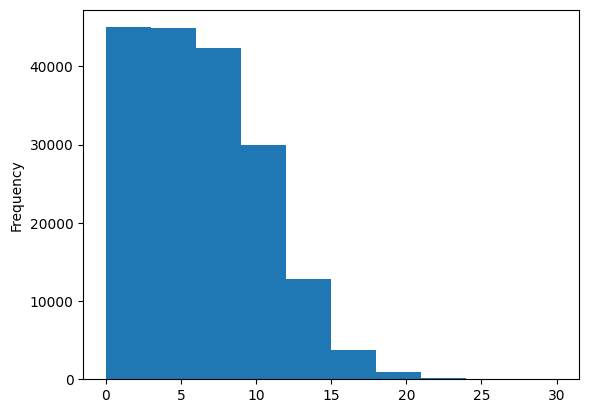

In [72]:
train_df.line_number.plot.hist()


In [32]:
depth = 15  

train_line_number_ohe = tf.one_hot(train_df['line_number'].tolist(),depth = depth)
val_line_number_ohe = tf.one_hot(val_df['line_number'].tolist(),depth = depth)
test_line_number_ohe = tf.one_hot(test_df['line_number'].tolist(),depth = depth)

In [82]:
train_line_number_ohe

<tf.Tensor: shape=(180040, 15), dtype=float32, numpy=
array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

<Axes: ylabel='Frequency'>

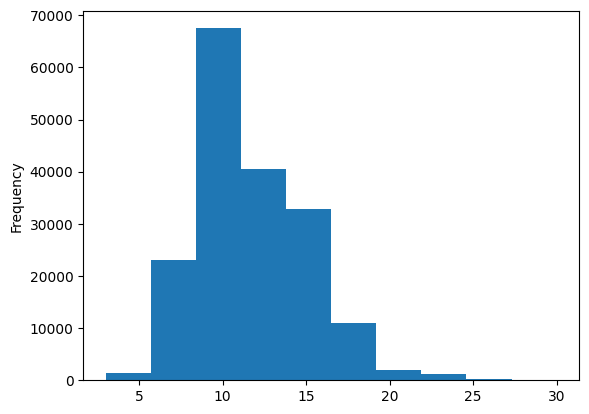

In [86]:
train_df['total_lines'].plot.hist()

In [33]:
depth_tl = 20
train_total_line_ohe = tf.one_hot(train_df['total_lines'].tolist(),depth = depth_tl)
val_total_line_ohe = tf.one_hot(val_df['total_lines'].tolist(),depth = depth_tl)
test_total_line_ohe = tf.one_hot(test_df['total_lines'].tolist(),depth = depth_tl)

In [36]:

#token inputs
tok_inputs = Input(shape=[],dtype = tf.string,name="token_inputs") #pretrained asks for size(batch,) hence shape= []
tok_emb = tf_hub_embedding_layer(tok_inputs)
x = Dense(128,activation = 'relu')(tok_emb)
tok_model = Model(tok_inputs,x)

# char inputs
char_inputs = layers.Input(shape=(1,), dtype="string")
char_vectors = tv_char(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(32))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)


#line_number inputs
line_n_inp = Input(shape = (15,),dtype=tf.int32, name="line_number_input")
x = Dense(32,activation = 'relu')(line_n_inp)
line_model = Model(line_n_inp , x)


#total_lines
total_line_inp = Input(shape = (20,),dtype = tf.int32,name="total_lines_input")
y = Dense(32,activation = 'relu')(total_line_inp)
total_line_model = Model(total_line_inp , y)

comb_emb = layers.Concatenate(name='tok_char_emb')([tok_model.output,
                                                    char_model.output])

z  = layers.Dropout(0.3)(comb_emb)
z = Dense(128,activation='relu')(z)
z = layers.Concatenate(name='line_n_post_n')([line_model.output,
                                              total_line_model.output,
                                              z])

output_layer = Dense(5,activation = 'softmax')(z)

model_5 = Model([line_model.input,
                 total_line_model.input,
                 tok_model.input,
                 char_model.input],
                output_layer )


In [37]:
model_5.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['input_2[0][0]']                
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['token_inputs[0][0]']    

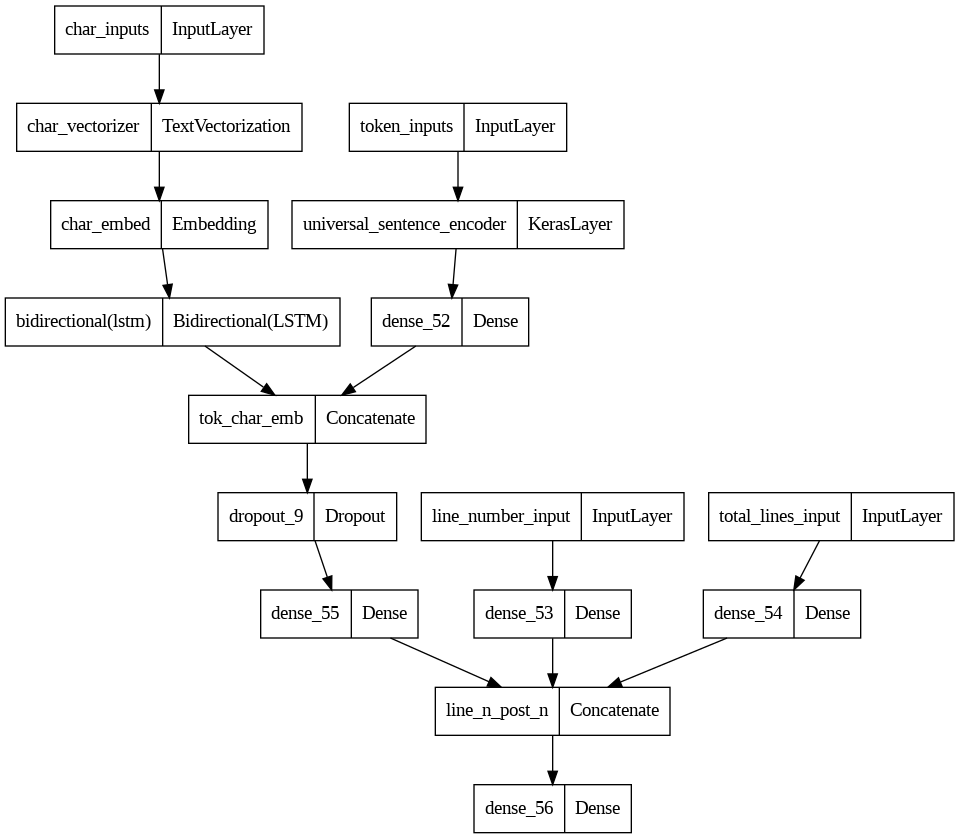

In [101]:
from tensorflow.keras.utils import plot_model
plot_model(model_5)

In [38]:
# Compile token, char, positional embedding model
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # add label smoothing (examples which are really confident get smoothed a little)
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
     

In [39]:
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((
    train_line_number_ohe, train_total_line_ohe,train_sent,train_chars))

train_pos_char_token_label = tf.data.Dataset.from_tensor_slices(train_labels_ohe)
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data,train_pos_char_token_label))
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


#validation dataset
val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((
    val_line_number_ohe, val_total_line_ohe,val_sent,val_chars))

val_pos_char_token_label = tf.data.Dataset.from_tensor_slices(val_labels_ohe)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data,val_pos_char_token_label))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)




In [40]:
# Fit the token, char and positional embedding model
history_model_5 = model_5.fit(train_pos_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_pos_char_token_dataset)),
                              epochs=3,
                              validation_data=val_pos_char_token_dataset,
                              validation_steps=int(0.1 * len(val_pos_char_token_dataset)))
     

Epoch 1/3
562/562 [==============================] - 166s 279ms/step - loss: 1.1104 - accuracy: 0.7131 - val_loss: 0.9950 - val_accuracy: 0.7992
Epoch 2/3
562/562 [==============================] - 151s 269ms/step - loss: 0.9751 - accuracy: 0.8053 - val_loss: 0.9582 - val_accuracy: 0.8211
Epoch 3/3
562/562 [==============================] - 155s 276ms/step - loss: 0.9573 - accuracy: 0.8148 - val_loss: 0.9459 - val_accuracy: 0.8268


In [109]:
print(model_5.evaluate(val_pos_char_token_dataset))
model_5_pred_probs = model_5.predict(val_pos_char_token_dataset)
model_5_pred_pred = tf.argmax(model_5_pred_probs,axis=1)
baseline_5_res = calculate(val_labels_encoded,model_5_pred_pred)

945/945 [==============================] - 37s 39ms/step - loss: 0.9406 - accuracy: 0.8303
[0.9405918717384338, 0.8302661180496216]
945/945 [==============================] - 19s 20ms/step
Recall:  0.830266119422746
precision:  0.8293969016467039
f1:  0.8293491648392926
accuracy:  0.830266119422746


In [111]:
baseall_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "custom_token_embed_conv1d": baseline_1_res,
                                  "pretrained_token_embed": baseline_2_res,
                                  "custom_char_embed_conv1d": baseline_3_res,
                                  "hybrid_char_token_embed": baseline_4_res,
                                  "tribrid_pos_char_token_embed": baseline_5_res})

all_model_results = baseall_model_results.transpose()
all_model_results

,accuracy,f1,precision,Recall
baseline,0.721832,0.698925,0.718647,0.721832
custom_token_embed_conv1d,0.806004,0.803569,0.802966,0.806004
pretrained_token_embed,0.708229,0.704825,0.707971,0.708229
custom_char_embed_conv1d,0.419668,0.333242,0.387136,0.419668
hybrid_char_token_embed,0.665861,0.637358,0.641321,0.665861
tribrid_pos_char_token_embed,0.830266,0.829349,0.829397,0.830266


In [112]:
model_5.save('skimlit_tribid_model')

In [116]:
!cp skimlit_tribid_model -r /content/drive/MyDrive/Tensorflow_cert/skimlit_models

In [120]:
path = '/content/drive/MyDrive/Tensorflow_cert/skimlit_models/skimlit_tribid_model/saved_model.pb'

loaded_model = tf.keras.models.load_model('/content/skimlit_tribid_model/saved_model.pb')

OSError: ignored

# Evaluate on test data

In [41]:
test_pos_char_token_data = tf.data.Dataset.from_tensor_slices((
    test_line_number_ohe,test_total_line_ohe,test_sent,test_chars
))
test_pos_char_token_label = tf.data.Dataset.from_tensor_slices((
    test_labels_ohe
))
test_pos_char_token_dataset = tf.data.Dataset.zip((test_pos_char_token_data,test_pos_char_token_label))
test_pos_char_token_dataset = test_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [42]:
test_pred_prob = model_5.predict(test_pos_char_token_dataset)
test_pred_val = tf.argmax(test_pred_prob,axis = 1)


942/942 [==============================] - 61s 63ms/step


In [43]:
calculate(test_pred_val,test_labels_encoded)

Recall:  0.8251534760245561
precision:  0.8278387447132993
f1:  0.8261925463454998
accuracy:  0.8251534760245561


{'accuracy': 0.8251534760245561,
 'f1': 0.8261925463454998,
 'precision': 0.8278387447132993,
 'Recall': 0.8251534760245561}

In [44]:
import json
!wget https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/skimlit_example_abstracts.json

--2023-05-24 01:24:02--  https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/skimlit_example_abstracts.json
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘skimlit_example_abstracts.json’

skimlit_example_abs     [ <=>                ] 154.40K  --.-KB/s    in 0.1s    

2023-05-24 01:24:03 (1.07 MB/s) - ‘skimlit_example_abstracts.json’ saved [158110]



In [50]:
data = [
    {
        "abstract": "This RCT examined the efficacy of a manualized social intervention for children with HFASDs. Participants were randomly assigned to treatment or wait-list conditions. Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language. A response-cost program was applied to reduce problem behaviors and foster skills acquisition. Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures). Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents. High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity. Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.",
        "source": "https://pubmed.ncbi.nlm.nih.gov/20232240/",
        "details": "RCT of a manualized social treatment for high-functioning autism spectrum disorders"
    },
    {
        "abstract": "Postpartum depression (PPD) is the most prevalent mood disorder associated with childbirth. No single cause of PPD has been identified, however the increased risk of nutritional deficiencies incurred through the high nutritional requirements of pregnancy may play a role in the pathology of depressive symptoms. Three nutritional interventions have drawn particular interest as possible non-invasive and cost-effective prevention and/or treatment strategies for PPD; omega-3 (n-3) long chain polyunsaturated fatty acids (LCPUFA), vitamin D and overall diet. We searched for meta-analyses of randomised controlled trials (RCT's) of nutritional interventions during the perinatal period with PPD as an outcome, and checked for any trials published subsequently to the meta-analyses. Fish oil: Eleven RCT's of prenatal fish oil supplementation RCT's show null and positive effects on PPD symptoms. Vitamin D: no relevant RCT's were identified, however seven observational studies of maternal vitamin D levels with PPD outcomes showed inconsistent associations. Diet: Two Australian RCT's with dietary advice interventions in pregnancy had a positive and null result on PPD. With the exception of fish oil, few RCT's with nutritional interventions during pregnancy assess PPD. Further research is needed to determine whether nutritional intervention strategies during pregnancy can protect against symptoms of PPD. Given the prevalence of PPD and ease of administering PPD measures, we recommend future prenatal nutritional RCT's include PPD as an outcome.",
        "source": "https://pubmed.ncbi.nlm.nih.gov/28012571/",
        "details": "Formatting removed (can be used to compare model to actual example)"
    },
    {
        "abstract": "Mental illness, including depression, anxiety and bipolar disorder, accounts for a significant proportion of global disability and poses a substantial social, economic and heath burden. Treatment is presently dominated by pharmacotherapy, such as antidepressants, and psychotherapy, such as cognitive behavioural therapy; however, such treatments avert less than half of the disease burden, suggesting that additional strategies are needed to prevent and treat mental disorders. There are now consistent mechanistic, observational and interventional data to suggest diet quality may be a modifiable risk factor for mental illness. This review provides an overview of the nutritional psychiatry field. It includes a discussion of the neurobiological mechanisms likely modulated by diet, the use of dietary and nutraceutical interventions in mental disorders, and recommendations for further research. Potential biological pathways related to mental disorders include inflammation, oxidative stress, the gut microbiome, epigenetic modifications and neuroplasticity. Consistent epidemiological evidence, particularly for depression, suggests an association between measures of diet quality and mental health, across multiple populations and age groups; these do not appear to be explained by other demographic, lifestyle factors or reverse causality. Our recently published intervention trial provides preliminary clinical evidence that dietary interventions in clinically diagnosed populations are feasible and can provide significant clinical benefit. Furthermore, nutraceuticals including n-3 fatty acids, folate, S-adenosylmethionine, N-acetyl cysteine and probiotics, among others, are promising avenues for future research. Continued research is now required to investigate the efficacy of intervention studies in large cohorts and within clinically relevant populations, particularly in patients with schizophrenia, bipolar and anxiety disorders.",
        "source": "https://pubmed.ncbi.nlm.nih.gov/28942748/",
        "details": "Effect of nutrition on mental health"
    },
    {
        "abstract": "Hepatitis C virus (HCV) and alcoholic liver disease (ALD), either alone or in combination, count for more than two thirds of all liver diseases in the Western world. There is no safe level of drinking in HCV-infected patients and the most effective goal for these patients is total abstinence. Baclofen, a GABA(B) receptor agonist, represents a promising pharmacotherapy for alcohol dependence (AD). Previously, we performed a randomized clinical trial (RCT), which demonstrated the safety and efficacy of baclofen in patients affected by AD and cirrhosis. The goal of this post-hoc analysis was to explore baclofen's effect in a subgroup of alcohol-dependent HCV-infected cirrhotic patients. Any patient with HCV infection was selected for this analysis. Among the 84 subjects randomized in the main trial, 24 alcohol-dependent cirrhotic patients had a HCV infection; 12 received baclofen 10mg t.i.d. and 12 received placebo for 12-weeks. With respect to the placebo group (3/12, 25.0%), a significantly higher number of patients who achieved and maintained total alcohol abstinence was found in the baclofen group (10/12, 83.3%; p=0.0123). Furthermore, in the baclofen group, compared to placebo, there was a significantly higher increase in albumin values from baseline (p=0.0132) and a trend toward a significant reduction in INR levels from baseline (p=0.0716). In conclusion, baclofen was safe and significantly more effective than placebo in promoting alcohol abstinence, and improving some Liver Function Tests (LFTs) (i.e. albumin, INR) in alcohol-dependent HCV-infected cirrhotic patients. Baclofen may represent a clinically relevant alcohol pharmacotherapy for these patients.",
        "source": "https://pubmed.ncbi.nlm.nih.gov/22244707/",
        "details": "Baclofen promotes alcohol abstinence in alcohol dependent cirrhotic patients with hepatitis C virus (HCV) infection"
    }
]


abstracts = pd.DataFrame(data)

In [51]:
abstracts.head()

,abstract,source,details
0,This RCT examined the efficacy of a manualized...,https://pubmed.ncbi.nlm.nih.gov/20232240/,RCT of a manualized social treatment for high-...
1,Postpartum depression (PPD) is the most preval...,https://pubmed.ncbi.nlm.nih.gov/28012571/,Formatting removed (can be used to compare mod...
2,"Mental illness, including depression, anxiety ...",https://pubmed.ncbi.nlm.nih.gov/28942748/,Effect of nutrition on mental health
3,Hepatitis C virus (HCV) and alcoholic liver di...,https://pubmed.ncbi.nlm.nih.gov/22244707/,Baclofen promotes alcohol abstinence in alcoho...


In [53]:
from spacy.lang.en import English
nlp =English()
sentencizer = nlp.create_pipe('sentencizer')
nlp.add_pipe(sentencizer)
doc = nlp(example_ab)

In [62]:
#sentencizer = nlp.create_pipe('sentencizer')
#nlp.add_pipe('sentencizer')
doc = nlp(data[0]['abstract'])
abstract_lines = [str(sent)for sent in list(doc.sents)]

In [64]:
total_lines_in_sample = len(abstract_lines)
sample_lines =[]
for i, line in enumerate(abstract_lines):
  sample_dict = {}
  sample_dict['text'] = str(line)
  sample_dict['line_number'] = i
  sample_dict['total_lines'] = total_lines_in_sample
  sample_lines.append(sample_dict)

In [65]:
sample_lines

[{'text': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs.',
  'line_number': 0,
  'total_lines': 8},
 {'text': 'Participants were randomly assigned to treatment or wait-list conditions.',
  'line_number': 1,
  'total_lines': 8},
 {'text': 'Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.',
  'line_number': 2,
  'total_lines': 8},
 {'text': 'A response-cost program was applied to reduce problem behaviors and foster skills acquisition.',
  'line_number': 3,
  'total_lines': 8},
 {'text': 'Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).',
  'line_number': 4,
  'total_lines': 8},
 {'text': 'Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.',
  'line_number': 5,
  'total_lines': 8},
 {'text'

In [66]:
test_abs_line_number = [line_n['line_number'] for line_n in sample_lines]
test_abstract_line_numbers_one_hot = tf.one_hot(test_abs_line_number,depth = 15)
test_abstract_line_numbers_one_hot

<tf.Tensor: shape=(8, 15), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],
      dtype=float32)>

In [67]:
# Get all total_lines values from sample abstract
test_abstract_total_lines = [line["total_lines"] for line in sample_lines]
# One-hot encode to same depth as training data, so model accepts right input shape
test_abstract_total_lines_one_hot = tf.one_hot(test_abstract_total_lines, depth=20)
test_abstract_total_lines_one_hot

<tf.Tensor: shape=(8, 20), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]], dtype=float32)>

In [69]:
abs_chars = [char_split(sent)for sent in abstract_lines]
abs_chars

['T h i s   R C T   e x a m i n e d   t h e   e f f i c a c y   o f   a   m a n u a l i z e d   s o c i a l   i n t e r v e n t i o n   f o r   c h i l d r e n   w i t h   H F A S D s .',
 'P a r t i c i p a n t s   w e r e   r a n d o m l y   a s s i g n e d   t o   t r e a t m e n t   o r   w a i t - l i s t   c o n d i t i o n s .',
 'T r e a t m e n t   i n c l u d e d   i n s t r u c t i o n   a n d   t h e r a p e u t i c   a c t i v i t i e s   t a r g e t i n g   s o c i a l   s k i l l s ,   f a c e - e m o t i o n   r e c o g n i t i o n ,   i n t e r e s t   e x p a n s i o n ,   a n d   i n t e r p r e t a t i o n   o f   n o n - l i t e r a l   l a n g u a g e .',
 'A   r e s p o n s e - c o s t   p r o g r a m   w a s   a p p l i e d   t o   r e d u c e   p r o b l e m   b e h a v i o r s   a n d   f o s t e r   s k i l l s   a c q u i s i t i o n .',
 'S i g n i f i c a n t   t r e a t m e n t   e f f e c t s   w e r e   f o u n d   f o r   f i v e   o f   s e v e n   p 

In [70]:
model_5.predict((test_abstract_line_numbers_one_hot,
                 test_abstract_total_lines_one_hot,
                 abstract_lines,
                 abs_chars))

ValueError: ignored